# Testing out numerical solver code

## current setup
crank-nicholson gmres solver and pme cell diffusion 

## Objectives 
* i think to do this you'll need to do a sweep over induction start and end times for each sender type. do this by starting and stopping simulations, toggling xSa/b to 0 and back, then continuing. 
* scale the size of the colony too? put in a no-amplify control as well?

## Model considerations 



$$ \partial_t c = F(c)$$
$$ \partial_t c = (D_a+2D_c)\nabla^2c + 2D_c|\nabla c|^2+f(c)$$
Crank-Nicolson approach is to take 
$$ \frac{c_{n+1}-c_n}{\Delta t} = \frac{F(c_n)+F(c_{n+1})}{2} $$
When jacobian is available
$$ c_{n+1} = c_n + \Delta t \frac{F(c_n)+F(c_n) + J(c)(c_{n+1}-c_n))}{2} $$
$$ (1 - \Delta t J(c)/2) c_{n+1}  = (1 - \Delta t J(c_n)/2)c_n  + \Delta t F(c)$$
$$ (D_a+2D_c)\nabla^2c_n + 2D_c|\nabla c_n|^2+f(c_n) + (D_a+2D_c)\nabla^2c_{n+1} + 2D_c|\nabla c_{n+1}|^2+f(c_{n+1})$$
$$ c_{n-1} = c_n \Delta t ((D_a+2D_c)\nabla^2c + 2D_c|\nabla c|^2+f(c)) $$



In [1]:
# imports
from __future__ import division, print_function

import itertools as itt
import time

import numpy as np
import pandas as pd
import os
import sys
import string
import selenium
import scipy.integrate as itg
import scipy.optimize as opt
import scipy.interpolate as itp
import scipy.ndimage as ndi
import scipy.sparse as sparse

import matplotlib as mpl
mpl.use("Agg")

import itertools

import matplotlib.pyplot as plt 
plt.rcParams['animation.ffmpeg_path'] = '/home/jparkin/anaconda3/bin/ffmpeg' # Add the path of ffmpeg here!!

import matplotlib.animation as anm
import skimage.measure
import skimage.filters
import numba
import gc

from multiprocessing import Pool, Process

# %load_ext memory_profiler
# %load_ext line_profiler
import timeit

from IPython.display import HTML

%matplotlib inline

In [2]:
plt.rcParams['animation.ffmpeg_path'] = '/home/jparkin/anaconda3/bin/ffmpeg' # Add the path of ffmpeg here!!
anm.writers.avail

/home/jparkin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The avail attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  


{'pillow': matplotlib.animation.PillowWriter,
 'ffmpeg': matplotlib.animation.FFMpegWriter,
 'ffmpeg_file': matplotlib.animation.FFMpegFileWriter,
 'imagemagick': matplotlib.animation.ImageMagickWriter,
 'imagemagick_file': matplotlib.animation.ImageMagickFileWriter,
 'html': matplotlib.animation.HTMLWriter}

In [2]:
import multiprocessing

In [3]:
# os.environ['OMP_NUM_THREADS'] = '8'

## 2D Discrete Laplacian

In continuous form : 
$$ U_t = \triangle U - \lambda U $$

In discrete form, for point $i$ : 
$$ \Delta U_i = \sum_{1 = w(i,j)}\omega(i,j)(U_i - U_j) - \lambda U_i $$

Use discrete laplacian approximation w/o diagonals for grid spacing, so that we can have zero-flux  boundary conditions. 

$$ L = 
 \begin{pmatrix}
  0 & 1 & 0 \\
  1 & -4 & 1 \\
  0 & 1 & 0 
 \end{pmatrix} $$

I use a convolution function to calculate the diffusion terms. 

# Try to find out why solvers quit with too_small_step error

In [2]:
import importlib
from omnisim import pme_coincidence_omnisim as oms
oms = importlib.reload(oms)
# array([1.13884719e-06, 2.57810284e-04, 6.79690366e+01, 3.97094713e+00,
#        1.57994650e-02])

# Params :    ,Dc,    rc,       rS, rR,  Hn, Kn,   Dn,      kn,                   
p0 = np.array([5e-8,  2.6e-4, 2e-4, 8e-6,  4, 68,  1.14e-6, (1.6e-2), 
# Da,   xa,                xs,  xS,
2e-4, (1e-6)/(16/2.25), 250, 300, 
#xr, hS,   kS,  hR, kR,  hC,  kC,    pa,  leak   min_od
13, 2.5,  133, 2.3, 40, 2.2, 1.13e4, 3e-5, 0.2, 0.02], dtype=np.float64)
# Define parameter values to sample
Dc,rc,rS,rR,Hn,Kn,Dn,kn,Da,xa,xs,xS,xr,hS,kS,hR,kR,hC,kC,pa,leak,min_od = p0

# Params :    ,Dc,    rc,    rS,   rR,    Hn,Kn,   Dn,     kn,       Daa,  Dab,   xa,  xs,  xSa, xSb
p0 = np.array([1e-7,  2.6e-4, 2e-4, 8e-5,  4, 68,  1.14e-6, 1.6e-2, 2e-4, 2e-4, (1e-7), 250, 300, 300,
#xr, hS,   kS,  hR, kR,  hC,  kC,    pa,  leak   min_od
13, 2.5,  133, 2.3, 40, 2.2, 1.13e4, 3e-5, 0, 0.02], dtype=np.float64)
# Define parameter values to sample
Dc,rc,rS,rR,Hn,Kn,Dn,kn,Daa,Dab,xa,xs,xSa,xSb,xr,hS,kS,hR,kR,hC,kC,pa,leak,min_od = p0
od0 = 1
cr_i, csa_i, csb_i, cp_i, n_i, aa_i, ab_i, sa_i, sb_i, ra_i, rb_i, o_i = np.arange(12)
simmer = oms.Simulator(scale=16)
# simmer.set_scale(4)
# simmer.t_eval = np.arange(0,24*60,2).astype(np.float)

NameError: name 'cpa_i' is not defined

In [ ]:
1/(Da*6*simmer.scale**2)

In [168]:
def new_init_conditions(simmer, weights=[1,1,1,6,6]):
    w_vec = np.array(weights)
    w_vec = w_vec/np.sum(w_vec)
    simmer.basedims = np.array([3,3])
    simmer.set_scale(simmer.scale)
    scale = simmer.scale
    simmer.t_eval = np.linspace(0,11*60*60,200)
    ns, nh, nw = simmer.initial_array.shape
    simmer.initial_array = np.zeros_like(simmer.initial_array)
    simmer.initial_array[n_i,:,:] = 100
    odval = 3e-3*simmer.scale**2
    r_vec = np.linspace(1e-3,0.7)*scale
    appx_distr = (r_vec)/np.sum(r_vec)
    ci_vec = [cr_i,csa_i,csb_i,cpa_i,cpb_i]
    for ci, ci_spots in zip(ci_vec, weights):
        for i in range(np.int(ci_spots)):
            r = np.random.choice(r_vec,1,p=appx_distr)
            theta = np.random.uniform(0,2*np.pi,size=(1,))
            x, y = np.int(r*np.cos(theta)+nw/2), np.int(r*np.sin(theta)+nh/2)
            simmer.initial_array[ci,y,x] = odval


In [169]:
new_init_conditions(simmer, weights=[1,1,1,200])

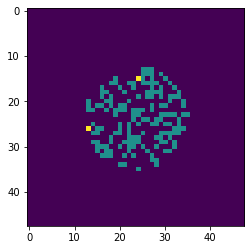

In [170]:
species = oms.species
cr_i, csa_i, csb_i, cp_i, n_i, aa_i, ab_i, sa_i, sb_i, ra_i, rb_i, o_i = np.arange(species)
plt.imshow(simmer.initial_array[:n_i,:,:].sum(axis=0),interpolation='none')

In [175]:
# simmer.set_p0(p0)

from omnisim.solvers import cn_gmres_2d_lineardiff as cn_gmres
cn_gmres = importlib.reload(cn_gmres)
# impexp = cn_gmres_2d.CNMGRK(simmer, 0, 2*60, first_step=5, rk_step=5e-2)

In [172]:
# Params :    ,Dc,    rc,    rS,   rR,    Hn,Kn,   Dn,     kn,       Daa,  Dab,   xa,  xs,  xSa,    xSb
p0 = np.array([1e-7,  2.6e-4, 2e-4, 8e-5,  4, 68,  1.14e-6, 1.6e-2, 2e-4, 2e-4, (1e-7), 250, 300, 300,
#xr, hS,   kS,  hR, kR,  hC,  kC,    pa,  leak   min_od
13, 2.5,  133, 2.3, 40, 2.2, 1.13e4, 3e-5, 0, 0.05], dtype=np.float64)
# Define parameter values to sample
Dc,rc,rS,rR,Hn,Kn,Dn,kn,Daa,Dab,xa,xs,xSa,xSb,xr,hS,kS,hR,kR,hC,kC,pa,leak,min_od = p0

In [173]:
loop_vars

[(0, 0, 1), (300, 0, 3), (300, 300, 5), (0, 300, 7), (0, 0, 12)]

In [72]:
t_prev

1

In [81]:
impexp.

(12, 48, 48)

In [210]:
ts1_vec = [3,5]
ts2_vec = [2,4]
pw_vec = [1,4]
itr_vec = [0,1,2]
ncs_vec = [1,3]
loop_vars = itertools.product(ts1_vec, ts2_vec, pw_vec, itr_vec, ncs_vec)
for ts1, ts2, pulse_width, itr, ncs in loop_vars:
    ns, nh, nw, _ = simmer.dims
    xs, xSa, xSb = 250, 300,300
    t1, t2, t3, t4 = ts1,ts2,ts1+pulse_width,ts2+pulse_width
    xsa_vars = np.array([(300,0,t1),(0,300,t2),(-300,0,t3),(0,-300,t4),(0,0,14)])
    xsa_vars = xsa_vars[np.argsort([t1,t2,t3,t4])]

[[   0  300    2]
 [ 300    0    3]
 [   0 -300    3]
 [-300    0    4]]
[[   0  300    2]
 [ 300    0    3]
 [   0 -300    3]
 [-300    0    4]]
[[   0  300    2]
 [ 300    0    3]
 [   0 -300    3]
 [-300    0    4]]
[[   0  300    2]
 [ 300    0    3]
 [   0 -300    3]
 [-300    0    4]]
[[   0  300    2]
 [ 300    0    3]
 [   0 -300    3]
 [-300    0    4]]
[[   0  300    2]
 [ 300    0    3]
 [   0 -300    3]
 [-300    0    4]]
[[   0  300    2]
 [ 300    0    3]
 [   0 -300    6]
 [-300    0    7]]
[[   0  300    2]
 [ 300    0    3]
 [   0 -300    6]
 [-300    0    7]]
[[   0  300    2]
 [ 300    0    3]
 [   0 -300    6]
 [-300    0    7]]
[[   0  300    2]
 [ 300    0    3]
 [   0 -300    6]
 [-300    0    7]]
[[   0  300    2]
 [ 300    0    3]
 [   0 -300    6]
 [-300    0    7]]
[[   0  300    2]
 [ 300    0    3]
 [   0 -300    6]
 [-300    0    7]]
[[ 300    0    3]
 [   0  300    4]
 [-300    0    4]
 [   0 -300    5]]
[[ 300    0    3]
 [   0  300    4]
 [-300    0    

In [208]:
import itertools

In [213]:

sim_tmpl = './worker_outputs/coinc_pw{}_t1{}_t2{}_{}_it{:0d}.tif'
tvc_tmpl = './worker_outputs/coinc_pw{}_t1{}_t2{}_{}_it{:0d}_tvc.npy'
ts1_vec = [3,5]
ts2_vec = [2,4]
pw_vec = [1,3,4]
itr_vec = [0,1,2]
loop_vars = itertools.product(ts1_vec, ts2_vec, pw_vec, itr_vec)
for ts1, ts2, pulse_width, itr in loop_vars:
    ns, nh, nw, _ = simmer.dims
    new_init_conditions(simmer,weights=[1,1,1,100])
    xs, xSa, xSb = 250, 0,0
    p0=np.array([Dc,rc,rS,rR,Hn,Kn,Dn,kn,Daa,Dab,xa,xs,xSa,xSb,xr,hS,kS,hR,kR,hC,kC,pa,leak,min_od])
    simmer.set_p0(p0)
    t1, t2, t3, t4 = ts1,ts2,ts1+pulse_width,ts2+pulse_width
    xsa_vars = np.array([(300,0,t1),(0,300,t2),(-300,0,t3),(0,-300,t4),(0,0,14)])
    xsa_vars = xsa_vars[np.argsort([t1,t2,t3,t4])]
    stack_list = []
    dt=3
    for xs, cnsr in zip([0,250],['sa','sr']):
        ys = []
        ts = []
        t_prev = 0
        impexp = cn_gmres.CNMGRK(simmer, 0, 0, first_step=dt, rk_step=dt/4)
        for d_xSa, d_xSb, t_len in xsa_vars:
            xSa += d_xSa
            xSb += d_xSb
            p0=np.array([Dc,rc,rS,rR,Hn,Kn,Dn,kn,Daa,Dab,xa,xs,xSa,xSb,xr,hS,kS,hR,kR,hC,kC,pa,leak,min_od])
            simmer.set_p0(p0)
            n_loops = np.int((t_len-t_prev)*3600/dt)
            rtime = time.time()
            for i in np.arange(n_loops):
                status, msg = impexp._step_impl()
                if status==False:
                    print(msg)
                    break
                if i%20:
                    continue
                else:
                    ys.append(impexp.y.copy())
                    ts.append(i*dt + t_prev*3600)
                if i%1000:
                    continue
                else:
                    print("iteration:{} dt:{}".format(i,dt))
                    print(dt*i/(time.time() - rtime))
            t_prev = t_len
            rtime = time.time() - rtime
        species, nh, nw, dx = simmer.dims
        ys_reshaped = [xx.reshape((1,species,nh,nw)) for xx in ys]
        ys_stack = np.concatenate(ys_reshaped,axis=0)
        out_fn = sim_tmpl.format(pulse_width,t1,t2,cnsr,itr)
        skimage.io.imsave(out_fn,ys_stack,plugin='tifffile')
        out_fn = tvc_tmpl.format(pulse_width,t1,t2,cnsr,itr)
        np.save(out_fn, np.array(ts))
        print(out_fn)

iteration:0 dt:3
0.0
iteration:1000 dt:3
159.73897025037326
iteration:2000 dt:3
160.14851826647708
iteration:0 dt:3
0.0
iteration:1000 dt:3
242.29230962527998
iteration:0 dt:3
0.0
iteration:1000 dt:3
235.41376283421368
./worker_outputs/coinc_pw1_t13_t22_sa_it0_tvc.npy
iteration:0 dt:3
0.0
iteration:1000 dt:3
173.7556609073321
iteration:2000 dt:3
174.61652233838734
iteration:0 dt:3
0.0
iteration:1000 dt:3
245.90779442675978
iteration:0 dt:3
0.0
iteration:1000 dt:3
242.8704066448789
./worker_outputs/coinc_pw1_t13_t22_sr_it0_tvc.npy
iteration:0 dt:3
0.0
iteration:1000 dt:3
170.3533932276207
iteration:2000 dt:3
170.09400324416399
iteration:0 dt:3
0.0
iteration:1000 dt:3
184.69755860500538
iteration:0 dt:3
0.0
iteration:1000 dt:3
244.39202993229947
./worker_outputs/coinc_pw1_t13_t22_sa_it1_tvc.npy
iteration:0 dt:3
0.0
iteration:1000 dt:3
324.97264779353446
iteration:2000 dt:3
342.27980235277323
iteration:0 dt:3
0.0
iteration:1000 dt:3
284.61448559207975
iteration:0 dt:3
0.0
iteration:1000 d

iteration:1000 dt:3
224.35698353839774
iteration:0 dt:3
0.0
iteration:1000 dt:3
222.68173079085872
iteration:2000 dt:3
224.07220450073262
iteration:0 dt:3
0.0
iteration:1000 dt:3
227.39170243085653
./worker_outputs/coinc_pw3_t13_t24_sa_it0_tvc.npy
iteration:0 dt:3
0.0
iteration:1000 dt:3
172.22204231449757
iteration:2000 dt:3
186.91049781767506
iteration:3000 dt:3
212.99884822729172
iteration:0 dt:3
0.0
iteration:1000 dt:3
243.59706266698774
iteration:0 dt:3
0.0
iteration:1000 dt:3
251.03335271641714
iteration:2000 dt:3
250.4204742011423
iteration:0 dt:3
0.0
iteration:1000 dt:3
253.6406803390895
./worker_outputs/coinc_pw3_t13_t24_sr_it0_tvc.npy
iteration:0 dt:3
0.0
iteration:1000 dt:3
184.9506963237371
iteration:2000 dt:3
169.46974864031495
iteration:3000 dt:3
164.16784261166828
iteration:0 dt:3
0.0
iteration:1000 dt:3
234.09734350214308
iteration:0 dt:3
0.0
iteration:1000 dt:3
234.06819317474475
iteration:2000 dt:3
234.215436505995
iteration:0 dt:3
0.0
iteration:1000 dt:3
235.24316485

iteration:1000 dt:3
288.0303232607321
iteration:2000 dt:3
288.0670981483953
iteration:3000 dt:3
288.3947297249806
./worker_outputs/coinc_pw3_t15_t22_sa_it1_tvc.npy
iteration:0 dt:3
0.0
iteration:1000 dt:3
375.47350410599245
iteration:2000 dt:3
375.13428704407306
iteration:0 dt:3
0.0
iteration:1000 dt:3
288.6017387648149
iteration:2000 dt:3
288.57395332041136
iteration:3000 dt:3
288.39084096553734
iteration:0 dt:3
0.0
iteration:1000 dt:3
284.9584954810901
iteration:2000 dt:3
284.01892776044406
iteration:3000 dt:3
282.17603534807114
./worker_outputs/coinc_pw3_t15_t22_sr_it1_tvc.npy
iteration:0 dt:3
0.0
iteration:1000 dt:3
367.6779834823974
iteration:2000 dt:3
374.96883308662535
iteration:0 dt:3
0.0
iteration:1000 dt:3
287.0047195191808
iteration:2000 dt:3
288.2445995308313
iteration:3000 dt:3
288.33475975341975
iteration:0 dt:3
0.0
iteration:1000 dt:3
287.9802633155414
iteration:2000 dt:3
287.91404006858824
iteration:3000 dt:3
288.4729590225381
./worker_outputs/coinc_pw3_t15_t22_sa_it2_t

iteration:3000 dt:3
373.1055893039351
iteration:4000 dt:3
373.43693048188317
iteration:0 dt:3
0.0
iteration:1000 dt:3
287.4059731295577
iteration:0 dt:3
0.0
iteration:1000 dt:3
283.0312842291877
iteration:2000 dt:3
282.39759365853064
iteration:0 dt:3
0.0
iteration:1000 dt:3
287.09330540639513
./worker_outputs/coinc_pw3_t15_t24_sa_it2_tvc.npy
iteration:0 dt:3
0.0
iteration:1000 dt:3
373.65274496823605
iteration:2000 dt:3
372.8958781366681
iteration:3000 dt:3
373.3355697954191
iteration:4000 dt:3
372.25915604578813
iteration:0 dt:3
0.0
iteration:1000 dt:3
287.53020996364614
iteration:0 dt:3
0.0
iteration:1000 dt:3
288.6114298494657
iteration:2000 dt:3
289.19416813346646
iteration:0 dt:3
0.0
iteration:1000 dt:3
284.88173476462407
./worker_outputs/coinc_pw3_t15_t24_sr_it2_tvc.npy
iteration:0 dt:3
0.0
iteration:1000 dt:3
375.2585531022898
iteration:2000 dt:3
350.58514248057594
iteration:3000 dt:3
324.864267164376
iteration:4000 dt:3
316.93397993976237
iteration:0 dt:3
0.0
iteration:1000 dt:

In [201]:

def write_movie(im_arr, t_vec, skip=1, n_frames=200):
    cr_i, cs_i, cp_i, n_i, a_i, s_i, r_i = np.arange(7)
    frames, s, h, w = im_arr.shape
    t_points = np.arange(0,t_vec.max(),n_frames)
    f_points = np.arange(frames)
    
    #frames = len(t)
    
    t, s, h, w = im_arr.shape
    xticks = []
    xticklabels = []
    # First set up the figure, the axis, and the plot element we want to animate
    blank_array = np.zeros([h, w])
    fig, axs = plt.subplots(2,3, figsize=(10,7))
    axs = axs.flatten()
    im_list = [0,0,0,0,0,0]
    
    # Plot cell densities
    ax_ind = 0
    ax = axs[ax_ind]
    indxs = [cp_i, cs_i, cr_i]
    vmax = im_arr[-1,indxs,:,:].sum(axis=0).max()
    vmin = im_arr[-1,indxs,:,:].sum(axis=0).min()
    im = ax.imshow(blank_array, animated=True, vmax=vmax, vmin=vmin, interpolation='none', aspect=1)
    cbar = fig.colorbar(im, ax=ax, ticks=[vmin, vmax])
    ax.set_xticks([])
    ax.set_xticklabels(xticklabels)
    ax.set_yticks([])
    ax.set_title('cell densities')
    im_list[ax_ind] = im
    
    # Plot nutrient densities
    ax_ind = 1
    ax = axs[ax_ind]
    indxs = [n_i]
    vmax = im_arr[:,indxs[0],:,:].max()
    vmin = im_arr[:,indxs[0],:,:].min()
    im = ax.imshow(blank_array, animated=True, vmax=vmax, vmin=vmin, interpolation='none', aspect=1)
    cbar = fig.colorbar(im, ax=ax, ticks=[vmin, vmax])
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    ax.set_yticks([])
    ax.set_title('nutrient')
    im_list[ax_ind] = im
    
    # Plot pulser synthase densities
    ax_ind = 2
    ax = axs[ax_ind]
    indxs = [s_i, cp_i]
    v_arr = im_arr[:,indxs,:,:].prod(axis=1)
    indxs = [s_i, cs_i]
    v_arr += im_arr[:,indxs,:,:].prod(axis=1)
    vmax = v_arr.max()
    vmin = v_arr.min()
    im = ax.imshow(blank_array, animated=True, vmax=vmax, vmin=vmin, interpolation='none', aspect=1)
    cbar = fig.colorbar(im, ax=ax, ticks=[vmin, vmax])
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    ax.set_yticks([])
    ax.set_title('synthases')
    im_list[ax_ind] = im
    
    # Plot ahl conc
    ax_ind = 3
    ax = axs[ax_ind]
    indxs = [a_i]
    v_arr = im_arr[:,indxs,:,:]
    vmax = v_arr.max()
    vmin = v_arr.min()
    im = ax.imshow(blank_array, animated=True, vmax=vmax, vmin=vmin, interpolation='none', aspect=1)
    cbar = fig.colorbar(im, ax=ax, ticks=[vmin, vmax])
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    ax.set_yticks([])
    ax.set_title('ahl')
    im_list[ax_ind] = im
    
    # Plot pulser repressor densities
    ax_ind = 4
    ax = axs[ax_ind]
    indxs = [r_i, cr_i]
    v_arr = im_arr[:,indxs,:,:].prod(axis=1)
    vmax = v_arr.max()
    vmin = v_arr.min()
    im = ax.imshow(blank_array, animated=True, vmax=vmax, vmin=vmin, interpolation='none', aspect=1)
    cbar = fig.colorbar(im, ax=ax, ticks=[vmin, vmax])
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    ax.set_yticks([])
    ax.set_title('repr')
    im_list[ax_ind] = im
    
    # Plot total cellular protein
    ax_ind = 5
    ax = axs[ax_ind]
    indxs = [s_i, r_i]
    v_arr = im_arr[:,indxs,:,:].sum(axis=1)
    vmax = v_arr.max()
    vmin = v_arr.min()
    im = ax.imshow(blank_array, animated=True, vmax=vmax, vmin=vmin, interpolation='none', aspect=1)
    cbar = fig.colorbar(im, ax=ax, ticks=[vmin, vmax])
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    ax.set_yticks([])
    ax.set_title('cellular protein')
    im_list[5] = im

    # animation function.  This is called sequentially
    t_points = np.linspace(0,t_vec.max(), 200)
    f_inds = []
    t_ind = 0
    for tp in t_points:
        while tp > t_vec[t_ind]:
            t_ind += 1
        f_inds.append(t_ind-1)
        
    def animate(t_point):
        cr_i, cs_i, cp_i, n_i, a_i, s_i, r_i = np.arange(7)
        i = f_inds[t_point]
        
        # Plot cell densities
        ax = axs[0]
        indxs = [cp_i, cs_i, cr_i]
        frame_arr = im_arr[i,indxs,:,:].sum(axis=0)
        im_list[0].set_array(frame_arr)

        # Plot nutrient densities
        ax = axs[1]
        indxs = [n_i]
        frame_arr = im_arr[i,indxs,:,:].sum(axis=0)
        im_list[1].set_array(frame_arr)

        # Plot synthase densities
        ax = axs[2]
        indxs = [s_i, cp_i]
        frame_arr = im_arr[i,indxs,:,:].prod(axis=0)
        indxs = [s_i, cs_i]
        frame_arr += im_arr[i,indxs,:,:].prod(axis=0)
        im_list[2].set_array(frame_arr)
        
        # Plot ahl
        ax = axs[3]
        indxs = [a_i]
        frame_arr = im_arr[i,indxs,:,:].sum(axis=0)
        im_list[3].set_array(frame_arr)

        # Plot repr
        ax = axs[4]
        indxs = [cr_i, r_i]
        frame_arr = im_arr[i,indxs,:,:].prod(axis=0)
        im_list[4].set_array(frame_arr)

        # Plot cellular protein
        ax = axs[5]
        indxs = [s_i, r_i]
        frame_arr = im_arr[i,indxs,:,:].sum(axis=0)
        im_list[5].set_array(frame_arr)

        #return im_list,

    # call the animator.  blit=True means only re-draw the parts that have changed.
    anim = anm.FuncAnimation(fig, animate, interval=50, frames=n_frames)

#     anim.save('./animation_test.gif', writer='pillow')
#     fig.tight_layout()
    plt.close('all')
    return anim
#     HTML(anim.to_html5_video())




In [215]:
! ls worker_outputs/coinc*it1.tif

worker_outputs/coinc_pw1_t13_t22_sa_it1.tif
worker_outputs/coinc_pw1_t13_t22_sr_it1.tif
worker_outputs/coinc_pw1_t13_t24_sa_it1.tif
worker_outputs/coinc_pw1_t13_t24_sr_it1.tif
worker_outputs/coinc_pw1_t15_t22_sa_it1.tif
worker_outputs/coinc_pw1_t15_t22_sr_it1.tif
worker_outputs/coinc_pw1_t15_t24_sa_it1.tif
worker_outputs/coinc_pw1_t15_t24_sr_it1.tif
worker_outputs/coinc_pw3_t13_t22_sa_it1.tif
worker_outputs/coinc_pw3_t13_t22_sr_it1.tif
worker_outputs/coinc_pw3_t13_t24_sa_it1.tif
worker_outputs/coinc_pw3_t13_t24_sr_it1.tif
worker_outputs/coinc_pw3_t15_t22_sa_it1.tif
worker_outputs/coinc_pw3_t15_t22_sr_it1.tif
worker_outputs/coinc_pw3_t15_t24_sa_it1.tif
worker_outputs/coinc_pw3_t15_t24_sr_it1.tif
worker_outputs/coinc_pw4_t13_t22_sa_it1.tif
worker_outputs/coinc_pw4_t13_t22_sr_it1.tif
worker_outputs/coinc_pw4_t13_t24_sa_it1.tif
worker_outputs/coinc_pw4_t13_t24_sr_it1.tif
worker_outputs/coinc_pw4_t15_t22_sa_it1.tif
worker_outputs/coinc_pw4_t15_t22_sr_it1.tif
worker_outputs/coinc_pw4_t15_t24

In [302]:

sim_tmpl = './worker_outputs/coinc_pw{}_t1{}_t2{}_{}_it{:0d}.tif'
amp_stack = skimage.io.imread(sim_tmpl.format(4,5,2,'sa',2))
null_stack = skimage.io.imread(sim_tmpl.format(4,5,2,'sr',2))

In [303]:
img = amp_stack

In [304]:
anim = write_movie(img[:,[cr_i,csa_i,cp_i,n_i,aa_i,sa_i,o_i],...],np.arange(img.shape[0]))
HTML(anim.to_html5_video())

In [305]:
anim = write_movie(img[:,[cr_i,csb_i,cp_i,n_i,ab_i,sb_i,o_i],...],np.arange(img.shape[0]))
HTML(anim.to_html5_video())

In [306]:
img = null_stack

In [307]:
anim = write_movie(img[:,[cr_i,csa_i,cp_i,n_i,aa_i,sa_i,o_i],...],np.arange(img.shape[0]))
HTML(anim.to_html5_video())

In [308]:
anim = write_movie(img[:,[cr_i,csb_i,cp_i,n_i,ab_i,sb_i,o_i],...],np.arange(img.shape[0]))
HTML(anim.to_html5_video())

In [3]:
ts1_vec = [3,5]
ts2_vec = [2,4]
pw_vec = [1,3,4]
itr_vec = [0,1,2]
cnsr_vec = ['sa','sr']
loop_vars = itertools.product(ts1_vec, ts2_vec, pw_vec, itr_vec,cnsr_vec)

sim_tmpl = './worker_outputs/coinc_pw{}_t1{}_t2{}_{}_it{:0d}.tif'
df_list = []
for ts1, ts2, pulse_width, itr,cnsr in loop_vars:
    in_fn = sim_tmpl.format(pulse_width,ts1,ts2,cnsr,itr)
    img = skimage.io.imread(in_fn)
    # keep reporter o_i concentrations where cell is above thresh
    amnt_vec = img[:,[cr_i,o_i],...].prod(axis=1).max(axis=0)
    bool_vec = img[-1,cr_i,...] > 0.5
    rep_vec = amnt_vec[bool_vec].flatten()
    df = pd.DataFrame({'fluor':rep_vec})
    df['ts1'] = ts1
    df['ts2'] = ts2
    df['pw'] = pulse_width
    df['itr'] = itr
    df['cnsr'] = cnsr
    ovlp = pulse_width - np.abs(ts1-ts2)
    df['ovlp'] = ovlp
    df_list.append(df)
all_df = pd.concat(df_list,ignore_index=True)

In [6]:
all_df[['ts1','ts2','pw','ovlp','minstart']].groupby(['ts1','ts2','pw','minstart']).agg(np.mean)

ovlp
ts1 ts2 pw minstart      
3   2   1  2            0
        3  2            2
        4  2            3
    4   1  3            0
        3  3            2
        4  3            3
5   2   1  2           -2
        3  2            0
        4  2            1
    4   1  4            0
        3  4            2
        4  4            3

In [5]:
all_df['minstart'] = all_df[['ts1','ts2']].min(axis=1)

In [11]:
sub_df.columns
['Fluorescence','Pulse 1','Pulse 2','Pulse Width','itr','Consortium','Overlap','Start Time']


Index(['fluor', 'ts1', 'ts2', 'pw', 'itr', 'cnsr', 'ovlp', 'minstart'], dtype='object')

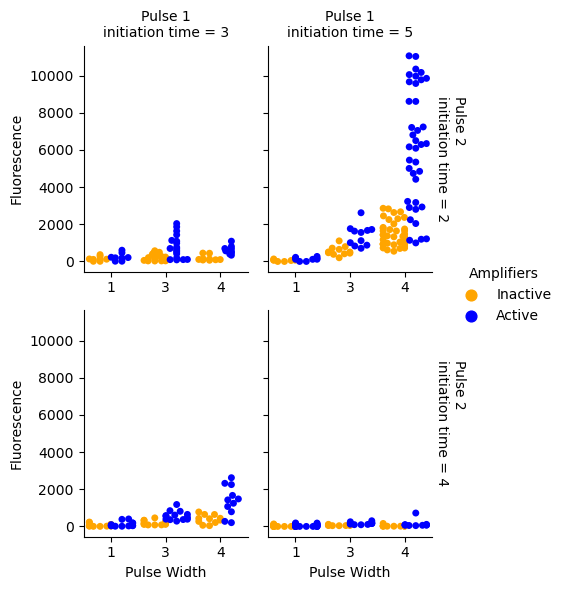

In [72]:
import seaborn as sns
plt.style.use('default')
plt.style.use('fast')
sub_df = all_df.loc[all_df.fluor>0,:].copy()
sub_df.columns = ['Fluorescence','Pulse 1\ninitiation time','Pulse 2\ninitiation time','Pulse Width','itr','Amplifiers','Overlap','Start Time']
conv_cnsr = lambda x : {'sa':'Inactive','sr':'Active'}[x]
sub_df['Amplifiers'] = sub_df['Amplifiers'].apply(conv_cnsr)
palette = {'Inactive':'orange','Active':'blue'}
# sub_df['logfluor'] = np.log10(sub_df.fluor.values)
# ri_dict = dict(zip([ra_i,rb_i,rc_i,rd_i],['1','2','3','4']))
# conv_ri = lambda x : ri_dict[x]
# sub_df['Chain Index'] = sub_df.ri.apply(conv_ri)
# sub_df['Sender\nMultiplicity'] = sub_df.ncs
# sub_df['Normalized\nResponse Difference'] = sub_df.logfluor-4
# fig, ax = plt.subplots(1,1,figsize=(7,4))
g = sns.catplot(x="Pulse Width", y='Fluorescence',hue="Amplifiers",col='Pulse 1\ninitiation time',row='Pulse 2\ninitiation time',
                data=sub_df, kind="swarm",height=3, aspect=0.8,palette=palette,dodge=True,
                sharey=True,sharex=False,margin_titles=True);
# yticks = np.arange(0.5,-3.5,-0.5)
# labels = []
# for ytick in yticks:
#     if (ytick%1)<0.2:
#         if ytick==0:
#             labels.append("1")
#         else:
#             labels.append("1/{:d}".format(np.int(10**np.abs(ytick))))
#     else:
#         labels.append('')
# g.axes[0][0].set_yticks(yticks)
# g.axes[0][0].set_yticklabels(labels)

In [73]:
# g.fig.tight_layout()
g.savefig('figs/coinc_comp.png',transparent=True,dpi=180)
g.savefig('figs/coinc_comp.pdf',transparent=True,dpi=180)

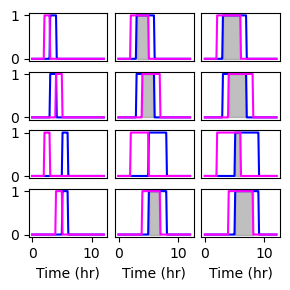

In [71]:
timing_df = all_df[['ts1','ts2','pw','ovlp','minstart']].groupby(['ts1','ts2','pw','minstart']).agg(np.mean).reset_index()
fig, axs = plt.subplots(4,3,figsize=(3,3))
x_vec = np.linspace(0,12,100)
y_vec = np.zeros_like(x_vec)
for i in np.arange(len(timing_df)):
    ts1, ts2, pw = timing_df.loc[i, ['ts1','ts2','pw']]
    ax = axs.flatten()[i]
    y_vec[:] = 0
    y_vec[((x_vec-ts1)>=0)&((x_vec-ts1)<=pw)] = 1
    ax.plot(x_vec, y_vec,'blue')
#     ax.fill_between(x_vec, y_vec,np.zeros_like(y_vec),,color='blue',alpha=0.3)
    y_vec[:] = 0
    y_vec[((x_vec-ts2)>=0)&((x_vec-ts2)<=pw)] = 1
    ax.plot(x_vec, y_vec,'magenta')
    b_vec = ((x_vec-ts2)>=0)&((x_vec-ts2)<=pw)&((x_vec-ts1)>=0)&((x_vec-ts1)<=pw)
    ax.fill_between(x_vec, y_vec, np.zeros_like(y_vec),b_vec,color='gray',alpha=0.5)
    ax.set_xticks([])
    ax.set_yticks([])
for ax in axs[:,0]:
    ax.set_yticks([0,1])

for ax in axs[-1,:]:
    ax.set_xticks([0,10])
    ax.set_xlabel('Time (hr)')
    
fig.tight_layout(h_pad=0.1,w_pad=0.2)

fig.savefig('figs/coinc_pulses.png',transparent=True,dpi=180)
fig.savefig('figs/coinc_pulses.pdf',transparent=True,dpi=180)

In [61]:
plt.fill_between?